In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

Les données proviennent de capteurs IoT (Internet of Things), probablement pour surveiller des produits ou des équipements. La colonne category semble représenter la classe (ou type) de produit à prédire.

In [ ]:
df = pd.read_csv('iot_sensor_data_with_category.csv')

 Lecture du fichier CSV contenant les données. Ce fichier semble contenir des mesures capteurs (features) et une étiquette de classification.

 On cherche ici à comprendre à quoi ressemblent les premiers et derniers enregistrements. Cela permet de vérifier que les données sont cohérentes et bien formatées.

In [ ]:
df.head()

,Timestamp,Sensor_ID,productid,productname,temperature,humidity,Status,category
0,2025-01-28 14:44:31,SENSOR-596,PR-001,Hair Serum 1,21.10,79.42,Alerte Température & Humidité,Haircare
1,2025-02-11 16:18:31,SENSOR-743,PR-002,Body Wash 2,19.79,57.33,Normal,Bodycare
2,2025-01-25 04:44:31,SENSOR-518,PR-003,Foot Cream 3,21.78,57.92,Normal,Bodycare
3,2025-01-19 07:22:31,SENSOR-823,PR-004,Conditioner 4,23.50,74.90,Normal,Haircare
4,2025-01-26 09:03:31,SENSOR-583,PR-005,Eau de Toilette 5,20.10,48.86,Alerte Humidité,Fragrance


In [ ]:
df.tail()

,Timestamp,Sensor_ID,productid,productname,temperature,humidity,Status,category
1196,2025-01-31 21:03:31,SENSOR-367,PR-2193,Hair Mask 1197,25.42,68.59,Normal,Haircare
1197,2025-02-09 14:56:31,SENSOR-545,PR-2195,Body Mist 1198,18.57,43.65,Alerte Température,Fragrance
1198,2025-01-27 09:15:31,SENSOR-531,PR-2197,Face Serum 1199,25.94,55.23,Alerte Température,Skincare
1199,2025-02-05 15:02:31,SENSOR-551,PR-2199,Eau de Toilette 1200,19.96,30.75,Alerte Humidité,Fragrance
1200,2025-01-18 22:55:31,SENSOR-832,PR-2201,Face Wash 1201,23.54,66.14,Alerte Humidité,Skincare


 Visualisation des premières et dernières lignes pour détecter d'éventuelles valeurs manquantes, colonnes inutiles, ou anomalies.

La date et l'heure des mesures (Timestamp) ne sont pas pertinentes pour la classification ou ne sont pas exploitables directement. Elle est donc supprimée.

In [ ]:
df = df.drop(columns=['Timestamp'], errors='ignore')

Suppression de la colonne Timestamp, potentiellement non utile pour l'entraînement du modèle. L’argument errors='ignore' garantit qu’une erreur ne sera pas levée si la colonne n’existe pas.

L’identifiant du capteur (Sensor_ID) n’apporte pas de valeur ajoutée pour la prédiction. Ce champ est probablement unique ou inutile dans ce contexte.

In [ ]:
df = df.drop(columns=['Sensor_ID'], errors='ignore')

Suppression d’une colonne non pertinente pour le modèle de Machine Learning.

Permet de voir combien de variables sont disponibles, le type de données pour chacune, et le nombre de valeurs manquantes éventuelles. Utile pour s’assurer que les données sont exploitables.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1201 entries, 0 to 1200
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   productid    1201 non-null   object 
 1   productname  1201 non-null   object 
 2   temperature  1201 non-null   float64
 3   humidity     1201 non-null   float64
 4   Status       1201 non-null   object 
 5   category     1201 non-null   object 
dtypes: float64(2), object(4)
memory usage: 56.4+ KB


Affiche les types (float64, object, etc.), le nombre de valeurs non nulles par colonne. Sert à diagnostiquer rapidement l’état du dataset.

Permet de connaître les plages de température, humidité, etc. Cela aide à identifier des valeurs aberrantes ou extrêmes (par exemple une température négative inattendue).
Résumé statistique : min, max, moyenne, écart-type, etc. pour chaque variable numérique.

In [ ]:
df.describe()

,temperature,humidity
count,1201.000000,1201.000000
mean,21.633397,51.921257
std,2.728103,11.802555
min,15.020000,30.000000
25%,19.580000,42.700000
50%,21.440000,51.330000
75%,23.770000,60.340000
max,27.980000,79.850000


Visualisation de la répartition des variables, utile pour comprendre le comportement des capteurs (valeurs normales, pics, etc.).

🛠️ Interprétation technique :
Boucle sur chaque colonne pour tracer des histogrammes avec courbe de densité (KDE). Aide à détecter les distributions anormales.



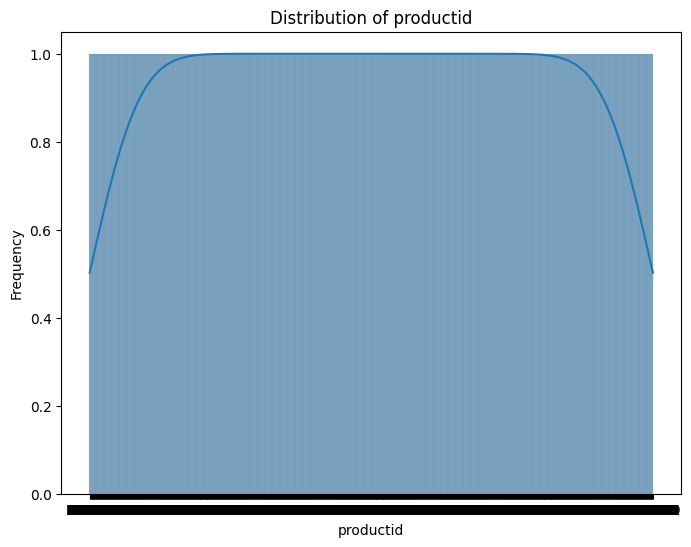

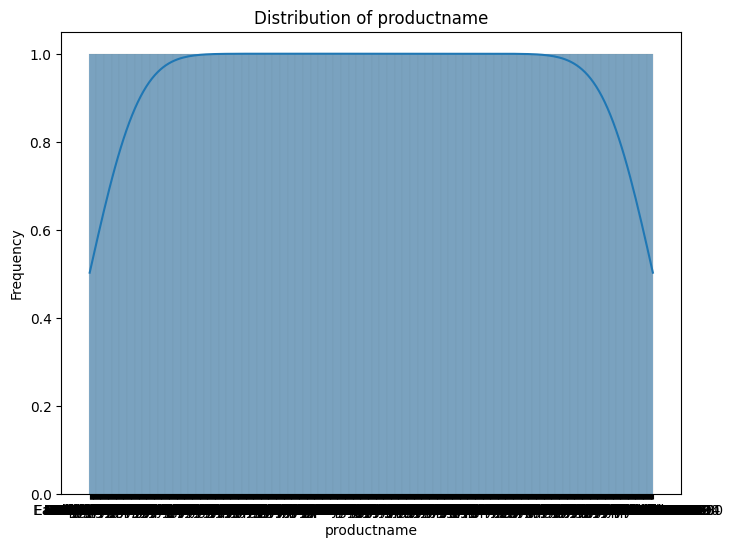

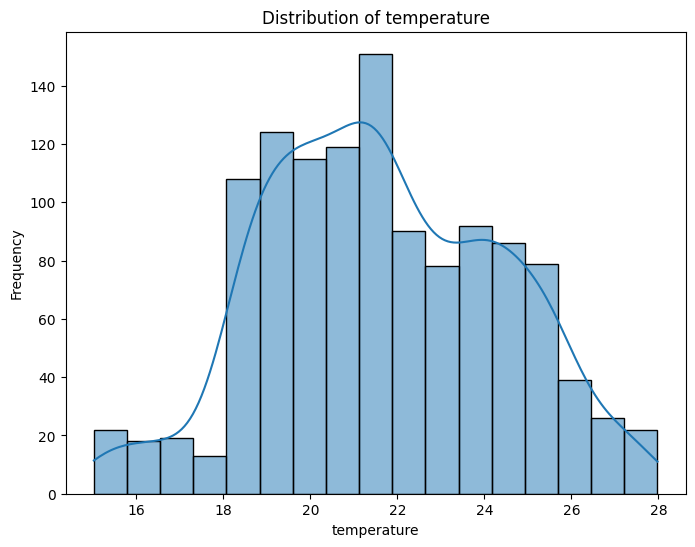

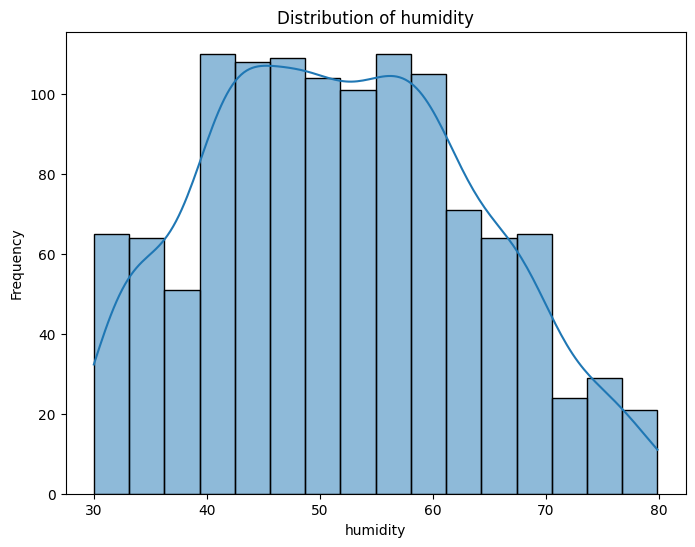

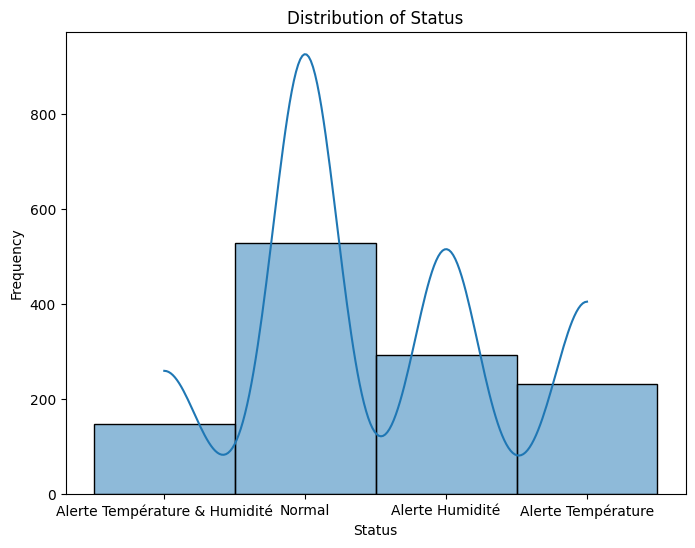

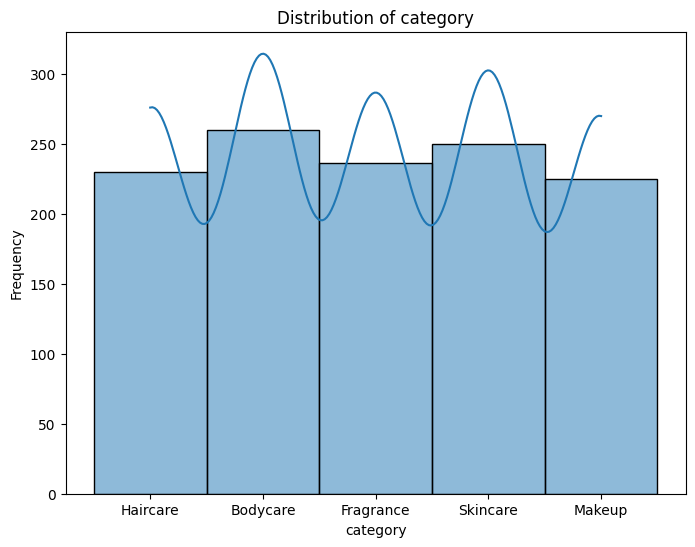

In [ ]:

import matplotlib.pyplot as plt

import seaborn as sns

for column in df.columns:
  plt.figure(figsize=(8, 6))
  sns.histplot(df[column], kde=True)
  plt.title(f"Distribution of {column}")
  plt.xlabel(column)
  plt.ylabel("Frequency")
  plt.show()


Vérifie si des capteurs ont échoué ou s’il manque des enregistrements pour certains produits.

In [ ]:
df.isnull().sum()


,0
productid,0
productname,0
temperature,0
humidity,0
Status,0
category,0


Comptage du nombre de valeurs NaN par colonne. Essentiel avant l’entraînement du modèle.

Cherche à savoir si température, humidité ou catégorie sont fortement liées à l’état (status) des produits.

Création d’une matrice de corrélation pour toutes les variables numériques. Peut aider à réduire la dimensionnalité ou à détecter des redondances.



In [ ]:
corr = df.corr(numeric_only=True)
corr

,temperature,humidity
temperature,1.000000,0.370387
humidity,0.370387,1.000000


Encoder la colonne Status en classes numériques

Transforme les libellés (Normal, Alerte, etc.) en valeurs numériques pour les utiliser dans un modèle prédictif.

Mapping manuel pour Status (vers une nouvelle colonne status_numerique)

Encodage automatique de la category par LabelEncoder.

In [ ]:
# prompt: ajouter column status_numerique qui a des valeur si status  0 = Normal, 1 = Alerte Température *, 2 = Alerte Humidité et 3 = Alerte Température & Humidité

# Create the 'status_numerique' column based on the 'Status' column
status_mapping = {
    'Normal': 0,
    'Alerte Température': 1,
    'Alerte Humidité': 2,
    'Alerte Température & Humidité': 3
}
df['status_numerique'] = df['Status'].map(status_mapping)
label_encoder = LabelEncoder()
df["category"] = label_encoder.fit_transform(df["category"])


In [ ]:
df

,productid,productname,temperature,humidity,Status,category,status_numerique
0,PR-001,Hair Serum 1,21.10,79.42,Alerte Température & Humidité,2,3
1,PR-002,Body Wash 2,19.79,57.33,Normal,0,0
2,PR-003,Foot Cream 3,21.78,57.92,Normal,0,0
3,PR-004,Conditioner 4,23.50,74.90,Normal,2,0
4,PR-005,Eau de Toilette 5,20.10,48.86,Alerte Humidité,1,2
...,...,...,...,...,...,...,...
1196,PR-2193,Hair Mask 1197,25.42,68.59,Normal,2,0
1197,PR-2195,Body Mist 1198,18.57,43.65,Alerte Température,1,1
1198,PR-2197,Face Serum 1199,25.94,55.23,Alerte Température,4,1
1199,PR-2199,Eau de Toilette 1200,19.96,30.75,Alerte Humidité,1,2


Les variables explicatives sont : température, humidité et catégorie du produit. L’objectif est de prédire l’état (status) du produit.


X : variables indépendantes (features)

y : variable cible à prédire (label)

In [ ]:
X = df[['temperature', 'humidity' , 'category']]
y = df['status_numerique']

On réserve 20% des données pour tester les performances du modèle. Cela garantit que l’évaluation sera faite sur des données que le modèle n’a jamais vues.

Utilisation de train_test_split avec un random_state pour reproductibilité. Création des ensembles train et test.



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle 1 : Random Forest

Random Forest est utilisé pour prédire si un produit est dans un état normal ou en alerte. Il est particulièrement adapté pour ce type de données hétérogènes.

Entraînement d’un modèle Random Forest avec 100 arbres. Évaluation avec un rapport de classification (précision, rappel, f1-score).

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
# Évaluation du modèle
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99        94
           1       0.98      0.96      0.97        45
           2       0.99      0.99      0.99        74
           3       0.96      0.93      0.95        28

    accuracy                           0.98       241
   macro avg       0.98      0.97      0.97       241
weighted avg       0.98      0.98      0.98       241



# Modèle 2 : Gradient Boosting

🧠 Interprétation métier :
Gradient Boosting est testé pour améliorer potentiellement la précision grâce à l’apprentissage séquentiel. Cela peut donner de meilleures performances dans des cas complexes.

🛠️ Interprétation technique :
Entraînement d’un modèle de boosting avec 100 itérations. Rapport de performance affiché

In [ ]:
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
print("Gradient Boosting:\n", classification_report(y_test, y_pred_gb))


Gradient Boosting:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93        94
           1       0.91      0.96      0.93        45
           2       0.94      0.82      0.88        74
           3       0.84      0.75      0.79        28

    accuracy                           0.90       241
   macro avg       0.89      0.88      0.88       241
weighted avg       0.90      0.90      0.90       241



# Modèle 3 : Support Vector Machine (SVM)

SVM permet une classification fine avec une frontière de décision optimisée. Il est utilisé pour tester une approche plus mathématiquement rigoureuse.

Modèle SVM avec noyau RBF (radial). Bon choix pour des données non linéaires. Rapport d'évaluation complet.



In [ ]:
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("SVM:\n", classification_report(y_test, y_pred_svm))

SVM:
               precision    recall  f1-score   support

           0       0.45      0.95      0.61        94
           1       0.00      0.00      0.00        45
           2       0.59      0.35      0.44        74
           3       0.00      0.00      0.00        28

    accuracy                           0.48       241
   macro avg       0.26      0.32      0.26       241
weighted avg       0.36      0.48      0.37       241



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Modèle 4 : K-Nearest Neighbors (KNN)

NN classe un produit en fonction de ses voisins les plus proches dans l’espace température/humidité/catégorie. C’est simple mais souvent efficace si les clusters sont bien définis.

Entraînement du modèle KNN avec k=5. Comparaison des prédictions avec les vraies valeurs de test via classification_report.



In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
print("KNN:\n", classification_report(y_test, y_pred_knn))


KNN:
               precision    recall  f1-score   support

           0       0.73      0.90      0.81        94
           1       0.78      0.62      0.69        45
           2       0.87      0.82      0.85        74
           3       0.79      0.54      0.64        28

    accuracy                           0.78       241
   macro avg       0.79      0.72      0.75       241
weighted avg       0.79      0.78      0.78       241

